In [1]:
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def load_clean_data():
    """
    Loads and cleans preset dataframes
    """
    global rainfall, maxtemp, mintemp, dmi, sam, soi #to make accessible outside of function
    
    rainfall = pd.read_csv('MelboureMonthlyRainfall.csv')
    maxtemp = pd.read_csv('MelbourneMonthlyMaxT.csv')
    mintemp = pd.read_csv('MelbourneMonthlyMinT.csv')
    dmi = pd.read_csv('dmi.had.long.data.csv')
    sam = pd.read_csv('sam.csv')
    soi = pd.read_csv('soi.csv')

    rainfall = rainfall.drop(['Product code','Station Number'],1)
    maxtemp = maxtemp.drop(['Product code','Station Number'],1)
    mintemp = mintemp.drop(['Product code','Station Number'],1)

    soi = soi.dropna()
    sam = sam.dropna()
    dmi = dmi.dropna()
    soi['MAR'] = pd.to_numeric(soi['MAR']) #March values were all string, convert back to float
    
    rainfall = rainfall.drop('Annual', axis = 1)
    maxtemp = maxtemp.drop('Annual', axis = 1)
    mintemp = mintemp.drop('Annual', axis = 1)

    sam = sam.rename(columns={'Unnamed: 0': 'YEAR'})
    dmi = dmi.rename(columns={'Unnamed: 0': 'YEAR'})
    rainfall.fillna(np.round(rainfall['Oct'].mean(),1), inplace=True) #fill NaN value with mean for the year
    maxtemp = maxtemp[maxtemp['Year']> 1970].reset_index().drop('index', axis =1).rename(columns={'Annual': 'AnnualMaxTemp'})
    rainfall= rainfall[rainfall['Year']> 1970].reset_index().drop('index', axis =1).rename(columns={'Annual': 'AnnualRainfall'})
    mintemp = mintemp[mintemp['Year']> 1970].reset_index().drop('index', axis =1).rename(columns={'Annual': 'AnnualMinTemp'})
    dmi = dmi[dmi['YEAR']> 1970].reset_index().drop('index', axis =1).drop(index=51)
    soi = soi[soi['YEAR']> 1970].reset_index().drop('index', axis =1)
    sam = sam[sam['YEAR']> 1970].reset_index().drop('index', axis =1)
    sam_int_year = sam['YEAR'].astype(int)
    sam = pd.merge(sam_int_year, sam, how = 'left')

    maxtemp.name = 'MaxT'
    mintemp.name = 'MinT'
    rainfall.name = 'Rainfall'
    dmi.name = 'DMI'
    soi.name = 'SOI'
    sam.name = 'SAM'

    


In [3]:
def get_seasonal_data():
    year_season = {'Years': [[year]*2 for year in range(1971,2022)]}
    year_season['Year'] = []
    year_season['Season']=[]
    for year in year_season['Years']:
        for y in year:
            year_season['Year'].append(y)

    year_season.pop('Years')

    for number in range(0, len(year_season['Year']), 2):
        year_season['Season'].append('W')
        year_season['Season'].append('S')
    ys = pd.DataFrame(year_season)
    
    factors = [mintemp, maxtemp, rainfall, dmi, sam, soi]
    factor_list = []
    for factor in factors:
        factor.columns = factor.columns.str.lower().str.capitalize()
        factor['WAvg']= factor[['Mar','Apr','May','Jun','Jul', 'Aug']].mean(axis=1)
        factor['SAvg']= factor[['Sep','Oct','Nov','Dec','Jan', 'Feb']].mean(axis=1)
        factor.drop(['Jan', 'Feb', 'Mar','Apr','May','Jun','Jul', 'Aug', 'Sep','Oct','Nov','Dec'], axis = 1, inplace= True)
    
    for factor in factors:
    
        factor_dict = {}
        factor_dict[factor.name] =[]

        for year in factor.Year:

            factor_dict[factor.name].append(factor[factor['Year']==year]['WAvg'].reset_index().iat[0,1])
            factor_dict[factor.name].append(factor[factor['Year']==year]['SAvg'].reset_index().iat[0,1])

        factor_df = pd.DataFrame(factor_dict)
        factor_list.append(factor_df)


    seasonal_data = pd.concat([ys, factor_list[0], factor_list[1], factor_list[2], factor_list[3], factor_list[4], factor_list[5]], axis = 1)
    
    return seasonal_data

In [4]:
def get_monthly_data():
    factors = [mintemp, maxtemp, rainfall, dmi, sam, soi]
    factor_list= []
    month_list = ['Jan', 'Feb', 'Mar','Apr','May','Jun','Jul', 'Aug', 'Sep','Oct','Nov','Dec']
    year_month = {'Years': [[year]*12 for year in range(1971,2022)]}
    year_month['Year'] = []
    year_month['Month']= []
    
    for year in year_month['Years']:
        for y in year:
            year_month['Year'].append(y)

    year_month.pop('Years')

    for number in range(1971, 2022):
        for month in month_list:
            year_month['Month'].append(month)
        
    ym = pd.DataFrame(year_month)
    

    for factor in factors:
        factor.columns = factor.columns.str.lower().str.capitalize()
        factor_dict = {}
        factor_dict[factor.name] =[]

        for year in factor.Year:
            for month in month_list:
                factor_dict[factor.name].append(factor[factor['Year']==year][month].reset_index().iat[0,1])

        factor_df = pd.DataFrame(factor_dict)
        factor_list.append(factor_df)


    monthly_data = pd.concat([ym, factor_list[0], factor_list[1], factor_list[2], factor_list[3], factor_list[4], factor_list[5]], axis = 1)


    return monthly_data

In [5]:
def add_flood_col_seasonal(dataframe):
    """
    Adds Flood column representing a categorical variable with 0 indicating flood did not occur during period and 1
    indicating flood occurrence
    
    :param dataframe: Dataframe object to add column to 
    :return: returns Dataframe object with added column
    """
    winter_floods = [1974, 1978, 1981, 1988, 1989, 1990, 1991, 1995, 2007]

    summer_floods = [1971, 1973, 1974, 1975, 1983,1984,1988,1991,1993,1995,1996,1998,1999,2003,2005,2007]
    
    dataframe['Flood'] = 0 

    # iterate through each winter year and update the Flood column to 1
    for year in winter_floods:
        mask = (dataframe['Year'] == year) & (dataframe['Season'] == 'W')
        dataframe.loc[mask, 'Flood'] = 1

    # iterate through each summer year and update the Flood column to 1
    for year in summer_floods:
        smask = (dataframe['Year'] == year) & (dataframe['Season'] == 'S')
        dataframe.loc[smask, 'Flood'] = 1
    return dataframe

In [6]:
def add_flood_col_month(dataframe):

    dataframe = get_monthly_data()

    flood_dict = {}

    flood_dict['Feb'] = [1971,1973, 2005, 2007]
    flood_dict['Apr'] = [1990]
    flood_dict['May'] = [1974]
    flood_dict['Jun'] = [1978,1988,1989,1995,2007]
    flood_dict['Aug'] = [1981,1991]
    flood_dict['Sep'] = [1983,1984,1988,1993,1998]
    flood_dict['Oct'] = [1973,1974,1975,1983,1993,1996]
    flood_dict['Nov'] = [1995]
    flood_dict['Dec'] = [1991,1998,1999,2003]

    dataframe['Flood'] = 0 


    # iterate through each winter year and update the Flood column to 1

    for my in flood_dict.items():
        for year in my[1]:
            mask = (dataframe['Month'] == my[0]) & (dataframe['Year'] == year)
            dataframe.loc[mask, 'Flood'] = 1

    return dataframe

In [7]:
load_clean_data()

get_monthly_data()

/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  rainfall = rainfall.drop(['Product code','Station Number'],1)
/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  maxtemp = maxtemp.drop(['Product code','Station Number'],1)
/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  mintemp = mintemp.drop(['Product code','Station Number'],1)


,Year,Month,MinT,MaxT,Rainfall,DMI,SAM,SOI
0,1971,Jan,15.8,26.0,90.4,0.264,-0.36,0.6
1,1971,Feb,17.2,28.0,100.7,0.093,0.16,3.3
2,1971,Mar,15.3,25.7,26.0,0.308,2.02,3.8
3,1971,Apr,12.5,21.9,48.6,0.315,-1.24,2.8
4,1971,May,9.0,16.4,61.0,0.006,-2.48,1.4
...,...,...,...,...,...,...,...,...
607,2021,Aug,8.5,16.4,49.6,0.014,0.73,1.0
608,2021,Sep,9.6,18.2,68.6,0.048,1.68,1.3
609,2021,Oct,10.2,19.4,110.4,0.068,0.80,1.2
610,2021,Nov,11.8,20.6,96.6,0.192,2.69,1.6


In [8]:
def plt_confusion_matrix(cnf_matrix, cats, method):
    """
    Given actual target values and predicted values for a classifier 'method', 
    plots the confusion matrix
    """
    # write the confusion matrix to a dataframe with row and column names as the categories
    cmatrix = pd.DataFrame(cnf_matrix,columns=cats,index=cats) 
    f, ax = plt.subplots(figsize=(7,6)) # initialise the plots and axes
    sns.heatmap(cmatrix, annot=True, linewidths=.5) # plot the confusion matrix as a heatmap
    plt.title('Confusion matrix for '+method) # add a title, + concatenates two strings
    plt.ylabel('Actual label') # add a ylabel
    plt.xlabel('Predicted label') # add a xlabel
    # adjust the bottom and top of the figure, so we can view all of it
    bottom, top = ax.get_ylim()  # get the y axis limits
    ax.set_ylim(bottom + 0.5, top - 0.5); # adjust the y axis limits

In [9]:
load_clean_data()

seasonal_data = add_flood_col_seasonal(get_seasonal_data())

/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  rainfall = rainfall.drop(['Product code','Station Number'],1)
/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  maxtemp = maxtemp.drop(['Product code','Station Number'],1)
/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  mintemp = mintemp.drop(['Product code','Station Number'],1)


In [10]:
### Format all to have same feature labels 
## ATTEMPT TO REMOVE OUTLIER BEFORE DECIDING AGAINST
# factors = [mintemp, maxtemp, rainfall, dmi, sam, soi]

# #Removing outliers
# for factor in factors:
#     factor.columns = factor.columns.str.lower().str.capitalize()
#     for feature in list(factor.columns[1:]): #make features into iterable list 
#         q1 = factor[feature].quantile(0.25)
        
#         q3 = factor[feature].quantile(0.75)
#         IQR = q3-q1
#         lower_limit = q1 - (IQR*1.5)
#         upper_limit = q3 + (IQR*1.5)
#         factor.loc[factor[feature]<lower_limit,feature] = lower_limit
#         factor.loc[factor[feature]>upper_limit,feature] = upper_limit


<AxesSubplot:>

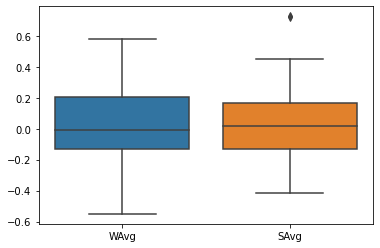

In [11]:
sns.boxplot(data=dmi.iloc[:, 1:])

<AxesSubplot:>

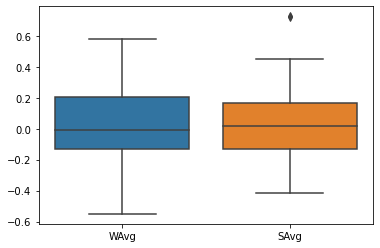

In [12]:
sns.boxplot(data=dmi.iloc[:, 1:])

# rainfall.iloc[:, 1:]

<AxesSubplot:xlabel='Rainfall', ylabel='DMI'>

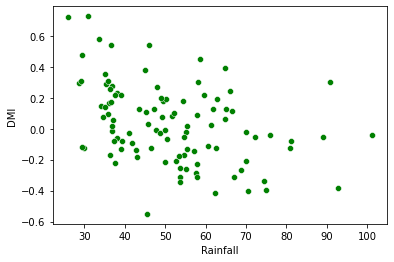

In [13]:
sns.scatterplot(data=seasonal_data,x='Rainfall',y='DMI',color='green')
#not strong correlation but seems maybe theres a trend with negative dmi and higher rainfall



<AxesSubplot:xlabel='Rainfall', ylabel='SOI'>

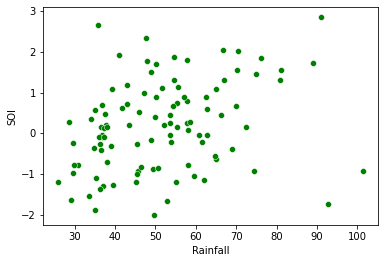

In [14]:
sns.scatterplot(data=seasonal_data,x='Rainfall',y='SOI',color='green')
#Slight positive correlation

<AxesSubplot:xlabel='Rainfall', ylabel='SAM'>

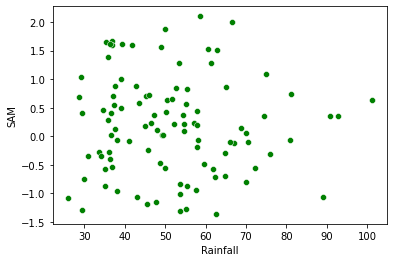

In [15]:
sns.scatterplot(data=seasonal_data,x='Rainfall',y='SAM',color='green')



In [16]:
winter_mask = seasonal_data['Season']=='W'
X = seasonal_data.loc[winter_mask][['DMI', 'SOI', 'SAM', 'MinT', 'MaxT']]
Y = seasonal_data.loc[winter_mask]['Flood']

# split into a training set with 80% of the data, and a testing set as the remainder
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42) 

logistic = LogisticRegression(fit_intercept=True) # instantatiate the linear regression model
logistic.fit(X_train,Y_train) # fit the data to the model

print("Intercept is",np.round(np.exp(logistic.intercept_),5))
print("Coefficients are",np.round(np.exp(logistic.coef_), 2))
    
pred_probs = logistic.predict_proba(X_train) #get predicted probabilities 
pred_probs = pd.DataFrame(pred_probs)

upper_qtile = pred_probs[1].quantile([0.75]).iloc[0]

pred_probs["class"] = np.where(pred_probs[1] > upper_qtile, 1, 0)

pred_probs["true"] = Y_train.reset_index().Flood

print('Training accuracy score is', {accuracy_score(pred_probs['true'],pred_probs['class'])})

test_preds = logistic.predict_proba(X_test)
test_preds = pd.DataFrame(test_preds)
test_preds['test_class'] = np.where(test_preds[1] > upper_qtile, 1, 0)
test_preds["true"] = Y_test.reset_index().Flood
print('Test accuracy score is', accuracy_score(test_preds['true'],test_preds['test_class']))

Intercept is [0.09929]
Coefficients are [[0.75 1.23 0.47 1.81 0.74]]
Training accuracy score is {0.75}
Test accuracy score is 0.9090909090909091


In [17]:
pred_probs[pred_probs['true']==1]

,0,1,class,true
5,0.726496,0.273504,1,1
7,0.582805,0.417195,1,1
30,0.652991,0.347009,1,1
32,0.890273,0.109727,0,1
34,0.885679,0.114321,0,1
35,0.811356,0.188644,0,1


In [18]:
test_preds

,0,1,test_class,true
0,0.852594,0.147406,0,0
1,0.813553,0.186447,0,0
2,0.922980,0.077020,0,0
3,0.855248,0.144752,0,0
4,0.792704,0.207296,1,1
5,0.796059,0.203941,1,0
6,0.577682,0.422318,1,1
7,0.916963,0.083037,0,0
8,0.679304,0.320696,1,1
9,0.836940,0.163060,0,0


In [19]:
summer_mask = seasonal_data['Season']=='S'
X = seasonal_data.loc[summer_mask][['DMI', 'SOI', 'SAM', 'MinT', 'MaxT']]
Y = seasonal_data.loc[summer_mask]['Flood']

# split into a training set with 80% of the data, and a testing set as the remainder
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42) 

logistic = LogisticRegression(fit_intercept=True) # instantatiate the linear regression model
logistic.fit(X_train,Y_train) # fit the data to the model

print("Intercept is",np.round(np.exp(logistic.intercept_),5))
print("Coefficients are",np.round(np.exp(logistic.coef_), 2))

pred_probs = logistic.predict_proba(X_train) #get predicted probabilities 
pred_probs = pd.DataFrame(pred_probs)

upper_qtile = pred_probs[1].quantile([0.75]).iloc[0]

pred_probs["class"] = np.where(pred_probs[1] > upper_qtile, 1, 0)

pred_probs["true"] = Y_train.reset_index().Flood

print('Training accuracy score is', {accuracy_score(pred_probs['true'],pred_probs['class'])})

test_preds = logistic.predict_proba(X_test)
test_preds = pd.DataFrame(test_preds)
test_preds['test_class'] = np.where(test_preds[1] > upper_qtile, 1, 0)
test_preds["true"] = Y_test.reset_index().Flood
print('Test accuracy score is', accuracy_score(test_preds['true'],test_preds['test_class']))

Intercept is [0.00772]
Coefficients are [[0.41 1.59 0.82 0.84 1.3 ]]
Training accuracy score is {0.75}
Test accuracy score is 0.6363636363636364


In [20]:
pred_probs[pred_probs['true']==1]

#this model had 6/14 correctly predicted, potentially suggesting that a larger outlook in terms of indices may be a
#better approach

,0,1,class,true
4,0.497815,0.502185,1,1
5,0.696118,0.303882,0,1
14,0.583660,0.416340,1,1
16,0.546800,0.453200,1,1
18,0.772933,0.227067,0,1
19,0.720145,0.279855,0,1
25,0.625360,0.374640,1,1
31,0.850134,0.149866,0,1
34,0.842586,0.157414,0,1
38,0.649202,0.350798,1,1


In [21]:
test_preds

,0,1,test_class,true
0,0.800967,0.199033,0,0
1,0.538062,0.461938,1,0
2,0.726712,0.273288,0,0
3,0.884012,0.115988,0,1
4,0.839099,0.160901,0,1
5,0.785483,0.214517,0,0
6,0.559242,0.440758,1,1
7,0.732836,0.267164,0,1
8,0.563839,0.436161,1,1
9,0.708208,0.291792,0,0


In [22]:
load_clean_data()

seasonal_data = add_flood_col_seasonal(get_seasonal_data())

/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  rainfall = rainfall.drop(['Product code','Station Number'],1)
/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  maxtemp = maxtemp.drop(['Product code','Station Number'],1)
/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  mintemp = mintemp.drop(['Product code','Station Number'],1)


In [23]:
seasonal_data.describe()

,Year,MinT,MaxT,Rainfall,DMI,SAM,SOI,Flood
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,1996.000000,11.437418,20.372549,51.427124,0.031154,0.189804,0.189216,0.245098
std,14.792291,1.719182,2.658403,15.588332,0.253314,0.853282,1.090265,0.432270
min,1971.000000,8.683333,16.750000,25.900000,-0.550667,-1.358333,-2.000000,0.000000
25%,1983.250000,9.783333,17.820833,37.525000,-0.133458,-0.447500,-0.762500,0.000000
50%,1996.000000,11.341667,20.166667,49.966667,0.002750,0.186667,0.166667,0.000000
75%,2008.750000,13.075000,23.045833,60.458333,0.193458,0.708333,0.900000,0.000000
max,2021.000000,14.400000,24.716667,101.266667,0.726333,2.101667,2.850000,1.000000


In [24]:
seasonal_data['code'] = seasonal_data.Flood.astype('category').cat.codes

Y= seasonal_data['code']

X = seasonal_data.loc[:,['DMI', 'SOI', 'SAM', 'MinT', 'MaxT']]

cat = ['Flood Did Not Occur', 'Flood Occurred']

Accuracy: 0.905


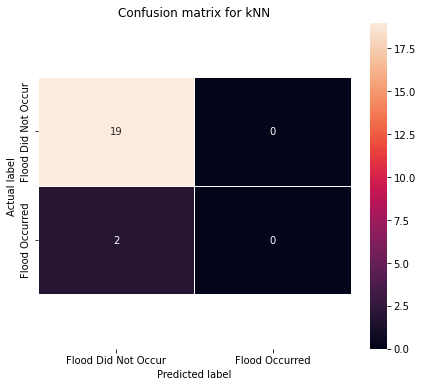

In [25]:
#Not normalised



X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=0.8,random_state=42)

n_neighbours = 10

clf = KNeighborsClassifier(n_neighbours, weights='uniform')
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test) #predictions for test

cnf_matrix = confusion_matrix(Y_test, Y_pred)
plt_confusion_matrix(cnf_matrix, cat, 'kNN')

print("Accuracy:",np.round(accuracy_score(Y_test, Y_pred),3)) # calculate and print the accuracy score



Accuracy: 0.857


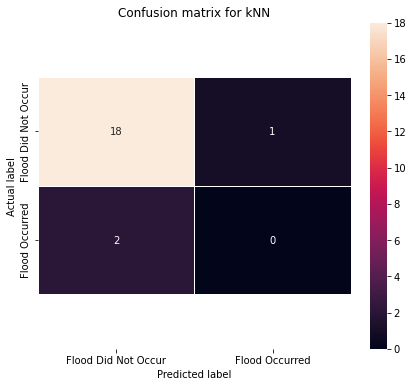

In [26]:
#Normalised

Xn = X/X.std()

X_train,X_test,Y_train,Y_test=train_test_split(Xn,Y,train_size=0.8,random_state=42)

n_neighbours = 10

clf = KNeighborsClassifier(n_neighbours, weights='uniform')
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)

cnf_matrix = confusion_matrix(Y_test, Y_pred)
plt_confusion_matrix(cnf_matrix, cat, 'kNN')
print("Accuracy:",np.round(accuracy_score(Y_test, Y_pred),3)) # calculate and print the accuracy score

In [27]:
seasonal_data.describe()

,Year,MinT,MaxT,Rainfall,DMI,SAM,SOI,Flood,code
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,1996.000000,11.437418,20.372549,51.427124,0.031154,0.189804,0.189216,0.245098,0.245098
std,14.792291,1.719182,2.658403,15.588332,0.253314,0.853282,1.090265,0.432270,0.432270
min,1971.000000,8.683333,16.750000,25.900000,-0.550667,-1.358333,-2.000000,0.000000,0.000000
25%,1983.250000,9.783333,17.820833,37.525000,-0.133458,-0.447500,-0.762500,0.000000,0.000000
50%,1996.000000,11.341667,20.166667,49.966667,0.002750,0.186667,0.166667,0.000000,0.000000
75%,2008.750000,13.075000,23.045833,60.458333,0.193458,0.708333,0.900000,0.000000,0.000000
max,2021.000000,14.400000,24.716667,101.266667,0.726333,2.101667,2.850000,1.000000,1.000000


In [28]:
seasonal_data

,Year,Season,MinT,MaxT,Rainfall,DMI,SAM,SOI,Flood,code
0,1971,W,9.483333,17.700000,41.050000,-0.031000,-0.081667,1.933333,0,0
1,1971,S,12.533333,22.216667,89.016667,-0.054500,-1.055000,1.716667,1,1
2,1972,W,8.683333,17.666667,29.533333,0.476000,-1.298333,-0.966667,0,0
3,1972,S,12.883333,22.866667,64.933333,0.395000,-0.696667,-0.633333,0,0
4,1973,W,8.983333,16.800000,55.466667,-0.130333,0.835000,1.150000,0,0
...,...,...,...,...,...,...,...,...,...,...
97,2019,S,13.050000,23.316667,25.900000,0.723333,-1.073333,-1.200000,0,0
98,2020,W,9.350000,17.100000,66.133333,0.246000,-0.105000,0.450000,0,0
99,2020,S,13.133333,22.650000,65.000000,0.127333,0.861667,1.100000,0,0
100,2021,W,9.700000,17.666667,47.133333,0.129167,0.370000,1.000000,0,0


In [29]:
# load_clean_data()

# seasonal_data = add_flood_col_seasonal(get_seasonal_data())

# q3 = seasonal_data.Rainfall.quantile(0.75)
    

# seasonal_data['Wet Season']  = 0
# wet_idx = []
# # Finding wet periods
# for idx, period in enumerate(seasonal_data.Rainfall):  
#     if period > q3:
#         print(f"Year {seasonal_data.Year[idx]} {seasonal_data.Season[idx]} was a wet season, with average rainfall of {period}")
#         wet_idx.append(idx)


# seasonal_data.iloc[[x for x in wet_idx], 9] = 1

# print('Correlation accuracy score with Flood is', {accuracy_score(seasonal_data['Flood'],seasonal_data['Wet Season'])})

In [30]:
load_clean_data()

monthly_data = add_flood_col_month(get_monthly_data())

X = monthly_data[['DMI', 'SOI', 'SAM', 'MinT', 'MaxT']]
Y = monthly_data['Flood']

# split into a training set with 80% of the data, and a testing set as the remainder
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42) 

logistic = LogisticRegression(fit_intercept=True) # instantatiate the linear regression model
logistic.fit(X_train,Y_train) # fit the data to the model

print("Intercept is",np.round(np.exp(logistic.intercept_),5))
print("Coefficients are",np.round(np.exp(logistic.coef_), 2))

pred_probs = logistic.predict_proba(X_train) #get predicted probabilities 
pred_probs = pd.DataFrame(pred_probs)

class_cat = pred_probs[1].mean() + (pred_probs[1].std()*3)

pred_probs["class"] = np.where(pred_probs[1] > class_cat, 1, 0)

pred_probs["true"] = Y_train.reset_index().Flood

print('Training accuracy score is', {accuracy_score(pred_probs['true'],pred_probs['class'])})

test_preds = logistic.predict_proba(X_test)
test_preds = pd.DataFrame(test_preds)
test_preds['test_class'] = np.where(test_preds[1] > class_cat, 1, 0)
test_preds["true"] = Y_test.reset_index().Flood
print('Test accuracy score is', accuracy_score(test_preds['true'],test_preds['test_class']))

/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  rainfall = rainfall.drop(['Product code','Station Number'],1)
/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  maxtemp = maxtemp.drop(['Product code','Station Number'],1)
/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  mintemp = mintemp.drop(['Product code','Station Number'],1)


Intercept is [0.2198]
Coefficients are [[0.2  1.07 1.02 1.43 0.76]]
Training accuracy score is {0.9406952965235174}
Test accuracy score is 0.975609756097561


In [31]:
pred_probs[pred_probs['true']==1]

,0,1,class,true
15,0.964270,0.035730,0,1
19,0.925556,0.074444,0,1
35,0.927527,0.072473,0,1
46,0.916433,0.083567,0,1
50,0.922364,0.077636,0,1
74,0.950326,0.049674,0,1
95,0.972883,0.027117,0,1
98,0.951909,0.048091,0,1
118,0.938639,0.061361,0,1
119,0.948186,0.051814,0,1


In [32]:
pred_probs.describe()

,0,1,class,true
count,489.000000,489.000000,489.000000,489.000000
mean,0.944785,0.055215,0.012270,0.055215
std,0.033276,0.033276,0.110201,0.228633
min,0.724105,0.003337,0.000000,0.000000
25%,0.931086,0.032742,0.000000,0.000000
50%,0.950784,0.049216,0.000000,0.000000
75%,0.967258,0.068914,0.000000,0.000000
max,0.996663,0.275895,1.000000,1.000000


In [33]:
pred_probs[pred_probs['true']==1]

###Note that despite the high accuracy score it only managed to predict 3/23 flood cases, making it a terrible
#form of preventative measure for floods.It just managed to resist false alarms

,0,1,class,true
15,0.964270,0.035730,0,1
19,0.925556,0.074444,0,1
35,0.927527,0.072473,0,1
46,0.916433,0.083567,0,1
50,0.922364,0.077636,0,1
74,0.950326,0.049674,0,1
95,0.972883,0.027117,0,1
98,0.951909,0.048091,0,1
118,0.938639,0.061361,0,1
119,0.948186,0.051814,0,1


In [34]:
##Retrying the model to see if it can get more flood cases correct, this time setting classification of true if
#the 1 values is greater than the mean of 1 values
load_clean_data()

monthly_data = add_flood_col_month(get_monthly_data())

X = monthly_data[['DMI', 'SOI', 'SAM', 'MinT', 'MaxT']]
Y = monthly_data['Flood']

# split into a training set with 80% of the data, and a testing set as the remainder
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42) 

logistic = LogisticRegression(fit_intercept=True) # instantatiate the linear regression model
logistic.fit(X_train,Y_train) # fit the data to the model

print("Intercept is",np.round(np.exp(logistic.intercept_),5))
print("Coefficients are",np.round(np.exp(logistic.coef_), 2))

pred_probs = logistic.predict_proba(X_train) #get predicted probabilities 
pred_probs = pd.DataFrame(pred_probs)

class_cat = pred_probs[1].mean() 

pred_probs["class"] = np.where(pred_probs[1] > class_cat, 1, 0)

pred_probs["true"] = Y_train.reset_index().Flood

print('Training accuracy score is', {accuracy_score(pred_probs['true'],pred_probs['class'])})

test_preds = logistic.predict_proba(X_test)
test_preds = pd.DataFrame(test_preds)
test_preds['test_class'] = np.where(test_preds[1] > class_cat, 1, 0)
test_preds["true"] = Y_test.reset_index().Flood
print('Test accuracy score is', accuracy_score(test_preds['true'],test_preds['test_class']))

/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  rainfall = rainfall.drop(['Product code','Station Number'],1)
/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  maxtemp = maxtemp.drop(['Product code','Station Number'],1)
/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  mintemp = mintemp.drop(['Product code','Station Number'],1)


Intercept is [0.2198]
Coefficients are [[0.2  1.07 1.02 1.43 0.76]]
Training accuracy score is {0.6155419222903885}
Test accuracy score is 0.6504065040650406


In [35]:
pred_probs[pred_probs['true']==1]

,0,1,class,true
15,0.964270,0.035730,0,1
19,0.925556,0.074444,1,1
35,0.927527,0.072473,1,1
46,0.916433,0.083567,1,1
50,0.922364,0.077636,1,1
74,0.950326,0.049674,0,1
95,0.972883,0.027117,0,1
98,0.951909,0.048091,0,1
118,0.938639,0.061361,1,1
119,0.948186,0.051814,0,1


In [36]:
test_preds[test_preds['true']==1]

,0,1,test_class,true
51,0.921092,0.078908,1,1
55,0.875389,0.124611,1,1


In [37]:
pred_probs

,0,1,class,true
0,0.967898,0.032102,0,0
1,0.981990,0.018010,0,0
2,0.996663,0.003337,0,0
3,0.964236,0.035764,0,0
4,0.921463,0.078537,1,0
...,...,...,...,...
484,0.978284,0.021716,0,0
485,0.946945,0.053055,0,0
486,0.946637,0.053363,0,0
487,0.974092,0.025908,0,0


In [38]:
##Retrying the model to see if it can get more flood cases correct, this time setting classification of true if
#the 1 values is greater than the mean of 1 values
load_clean_data()

monthly_data = add_flood_col_month(get_monthly_data())

X = monthly_data[['DMI', 'SOI', 'SAM', 'MinT', 'MaxT']]
Y = monthly_data['Flood']

# split into a training set with 80% of the data, and a testing set as the remainder
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42) 

logistic = LogisticRegression(fit_intercept=True) # instantatiate the linear regression model
logistic.fit(X_train,Y_train) # fit the data to the model

print("Intercept is",np.round(np.exp(logistic.intercept_),5))
print("Coefficients are",np.round(np.exp(logistic.coef_), 2))

pred_probs = logistic.predict_proba(X_train) #get predicted probabilities 
pred_probs = pd.DataFrame(pred_probs)

class_cat = pred_probs[1].mean() 

pred_probs["class"] = np.where(pred_probs[1] > class_cat, 1, 0)

pred_probs["true"] = Y_train.reset_index().Flood

print('Training accuracy score is', {accuracy_score(pred_probs['true'],pred_probs['class'])})

test_preds = logistic.predict_proba(X_test)
test_preds = pd.DataFrame(test_preds)
test_preds['test_class'] = np.where(test_preds[1] > class_cat, 1, 0)
test_preds["true"] = Y_test.reset_index().Flood
print('Test accuracy score is', accuracy_score(test_preds['true'],test_preds['test_class']))

/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  rainfall = rainfall.drop(['Product code','Station Number'],1)
/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  maxtemp = maxtemp.drop(['Product code','Station Number'],1)
/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  mintemp = mintemp.drop(['Product code','Station Number'],1)


Intercept is [0.2198]
Coefficients are [[0.2  1.07 1.02 1.43 0.76]]
Training accuracy score is {0.6155419222903885}
Test accuracy score is 0.6504065040650406


In [39]:
test_preds[test_preds['true']==1]

,0,1,test_class,true
51,0.921092,0.078908,1,1
55,0.875389,0.124611,1,1


In [40]:
# kNN

load_clean_data()

monthly_data = add_flood_col_month(get_monthly_data())

monthly_data['code'] = monthly_data.Flood.astype('category').cat.codes

Y= monthly_data['code']

X = monthly_data.loc[:,['DMI', 'SOI', 'SAM','MinT', 'MaxT']]

cat = ['Flood Did Not Occur', 'Flood Occurred']

/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  rainfall = rainfall.drop(['Product code','Station Number'],1)
/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  maxtemp = maxtemp.drop(['Product code','Station Number'],1)
/var/folders/cj/ygg3lwpn6tnf9nyrgnjxjs780000gn/T/ipykernel_2259/437028469.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  mintemp = mintemp.drop(['Product code','Station Number'],1)


Accuracy: 0.951


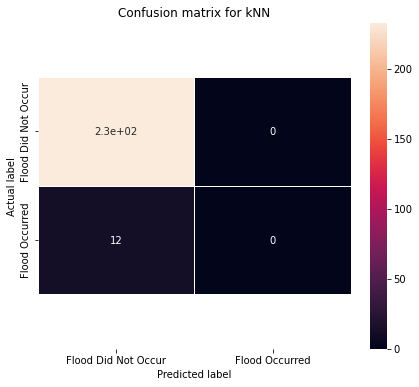

In [41]:
#Not normalised



X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=0.6,random_state=42)

n_neighbours = 10

clf = KNeighborsClassifier(n_neighbours, weights='uniform')
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test) #predictions for test

cnf_matrix = confusion_matrix(Y_test, Y_pred)
plt_confusion_matrix(cnf_matrix, cat, 'kNN')

print("Accuracy:",np.round(accuracy_score(Y_test, Y_pred),3)) # calculate and print the accuracy score

Accuracy: 0.984


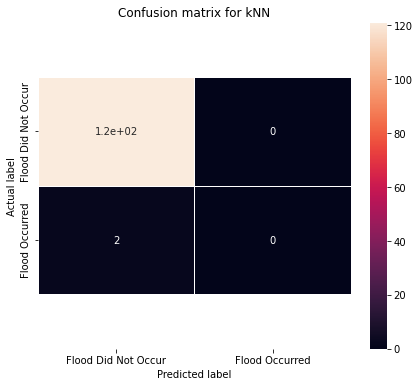

In [42]:
#Normalised

Xn = X/X.std()

X_train,X_test,Y_train,Y_test=train_test_split(Xn,Y,train_size=0.8,random_state=42)

n_neighbours = 10

clf = KNeighborsClassifier(n_neighbours, weights='uniform')
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)

cnf_matrix = confusion_matrix(Y_test, Y_pred)
plt_confusion_matrix(cnf_matrix, cat, 'kNN')
print("Accuracy:",np.round(accuracy_score(Y_test, Y_pred),3)) # calculate and print the accuracy score

In [43]:
#limitation that only 3% of the sample size resulted in flood. But shows resistance to false alarms

In [44]:
#Linear

X = monthly_data[['DMI', 'SOI', 'SAM','MinT', 'MaxT']]
Y = monthly_data['Rainfall']


linear = LinearRegression(fit_intercept=True) # instantatiate the linear regression model
linear.fit(X_train,Y_train) # fit the data to the model

print("Coefficients are",np.round(linear.coef_, 3))
print("Intercept is",np.round(linear.intercept_,3))

training_score = linear.score(X_train,Y_train) # calculate rsq for the training set
# use the independent variables for the testing set to predict the target variable
preds_linear = linear.predict(X_test) 
# calculate the correlation of the predicted and actual target variables
rsquared_linear = r2_score(Y_test,preds_linear) 
# print the training and testing scores
print("Training score is",np.round(training_score, 3))
print("Testing score is",np.round(rsquared_linear, 3))

Coefficients are [-0.035  0.001  0.002  0.049 -0.054]
Intercept is 0.128
Training score is 0.03
Testing score is -0.076


In [45]:
monthly_data.corr()

,Year,MinT,MaxT,Rainfall,DMI,SAM,SOI,Flood,code
Year,1.000000,0.085017,0.079080,-0.098376,0.279662,0.188778,0.028738,-0.109199,-0.109199
MinT,0.085017,1.000000,0.974302,0.004463,0.029310,0.060002,0.094572,-0.014624,-0.014624
MaxT,0.079080,0.974302,1.000000,-0.045645,0.060325,0.040516,0.050643,-0.032815,-0.032815
Rainfall,-0.098376,0.004463,-0.045645,1.000000,-0.210356,0.083146,0.137620,0.247327,0.247327
DMI,0.279662,0.029310,0.060325,-0.210356,1.000000,0.040467,-0.212593,-0.157823,-0.157823
SAM,0.188778,0.060002,0.040516,0.083146,0.040467,1.000000,0.091718,0.000203,0.000203
SOI,0.028738,0.094572,0.050643,0.137620,-0.212593,0.091718,1.000000,0.049104,0.049104
Flood,-0.109199,-0.014624,-0.032815,0.247327,-0.157823,0.000203,0.049104,1.000000,1.000000
code,-0.109199,-0.014624,-0.032815,0.247327,-0.157823,0.000203,0.049104,1.000000,1.000000


In [46]:
monthly_data.loc[monthly_data['SOI']>8]

,Year,Month,MinT,MaxT,Rainfall,DMI,SAM,SOI,Flood,code


In [47]:
# monthly_soi = pd.read_csv('soi_monthly.csv')

# monthly_soi.iloc[958]

In [48]:
# monthly_soi

In [49]:
# monthly_soi = monthly_soi[(monthly_soi.index>970)&(monthly_soi.index<1751)].reset_index().drop('index',axis=1)


In [50]:
# monthly_soi.iloc[0

In [51]:
# monthly_data.iloc[0,7]

In [52]:
# for x in monthly_data.index:
#         monthly_data.iloc[x,7] = monthly_soi.iloc[x,1]
    

In [53]:
monthly_data

,Year,Month,MinT,MaxT,Rainfall,DMI,SAM,SOI,Flood,code
0,1971,Jan,15.8,26.0,90.4,0.264,-0.36,0.6,0,0
1,1971,Feb,17.2,28.0,100.7,0.093,0.16,3.3,1,1
2,1971,Mar,15.3,25.7,26.0,0.308,2.02,3.8,0,0
3,1971,Apr,12.5,21.9,48.6,0.315,-1.24,2.8,0,0
4,1971,May,9.0,16.4,61.0,0.006,-2.48,1.4,0,0
...,...,...,...,...,...,...,...,...,...,...
607,2021,Aug,8.5,16.4,49.6,0.014,0.73,1.0,0,0
608,2021,Sep,9.6,18.2,68.6,0.048,1.68,1.3,0,0
609,2021,Oct,10.2,19.4,110.4,0.068,0.80,1.2,0,0
610,2021,Nov,11.8,20.6,96.6,0.192,2.69,1.6,0,0


In [54]:
monthly_data.corr()

,Year,MinT,MaxT,Rainfall,DMI,SAM,SOI,Flood,code
Year,1.000000,0.085017,0.079080,-0.098376,0.279662,0.188778,0.028738,-0.109199,-0.109199
MinT,0.085017,1.000000,0.974302,0.004463,0.029310,0.060002,0.094572,-0.014624,-0.014624
MaxT,0.079080,0.974302,1.000000,-0.045645,0.060325,0.040516,0.050643,-0.032815,-0.032815
Rainfall,-0.098376,0.004463,-0.045645,1.000000,-0.210356,0.083146,0.137620,0.247327,0.247327
DMI,0.279662,0.029310,0.060325,-0.210356,1.000000,0.040467,-0.212593,-0.157823,-0.157823
SAM,0.188778,0.060002,0.040516,0.083146,0.040467,1.000000,0.091718,0.000203,0.000203
SOI,0.028738,0.094572,0.050643,0.137620,-0.212593,0.091718,1.000000,0.049104,0.049104
Flood,-0.109199,-0.014624,-0.032815,0.247327,-0.157823,0.000203,0.049104,1.000000,1.000000
code,-0.109199,-0.014624,-0.032815,0.247327,-0.157823,0.000203,0.049104,1.000000,1.000000
